In [ ]:
import os

if 'datas_2' not in os.listdir():
    os.makedirs("datas_2")

## downlod data from web site
!gsutil cp gs://cartoonset_public_files/cartoonset10k.tgz /content/datas_2/cartoonset10k.tgz

Copying gs://cartoonset_public_files/cartoonset10k.tgz...
\ [1 files][454.6 MiB/454.6 MiB]                                                
Operation completed over 1 objects/454.6 MiB.                                    


In [ ]:
## dezip on the tmp dir
!tar -xzvf "/content/datas_2/cartoonset10k.tgz" -C "/content/datas_2/"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
cartoonset10k/cs11130198548099864740.csv
cartoonset10k/cs11130198548099864740.png
cartoonset10k/cs11130522928710913906.csv
cartoonset10k/cs11130522928710913906.png
cartoonset10k/cs11130692035407747496.csv
cartoonset10k/cs11130692035407747496.png
cartoonset10k/cs1113080672465802980.csv
cartoonset10k/cs1113080672465802980.png
cartoonset10k/cs11131138722323947780.csv
cartoonset10k/cs11131138722323947780.png
cartoonset10k/cs1113121412202668922.csv
cartoonset10k/cs1113121412202668922.png
cartoonset10k/cs11131333133753359573.csv
cartoonset10k/cs11131333133753359573.png
cartoonset10k/cs1113143340294813643.csv
cartoonset10k/cs1113143340294813643.png
cartoonset10k/cs11131732994961040179.csv
cartoonset10k/cs11131732994961040179.png
cartoonset10k/cs1113191746674328122.csv
cartoonset10k/cs1113191746674328122.png
cartoonset10k/cs11131958805482037869.csv
cartoonset10k/cs11131958805482037869.png
cartoonset10k/cs111326682978

In [ ]:
import keras
from keras import layers
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
import os


In [ ]:
latent_dim = 128#32
height = 128
width = 128
channels = 3

In [ ]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "/content/datas_2/", label_mode=None, image_size=(height, width), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 10000 files belonging to 1 classes.


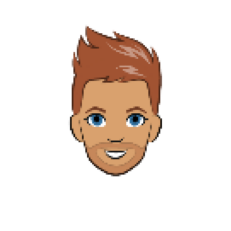

In [ ]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[4])
    break

In [ ]:
generator_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(128 * 64 * 64)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((64, 64, 128))(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 524288)            67633152  
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 524288)            0         
_________________________________________________________________
reshape (Reshape)            (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 128, 128, 256)     104883

In [ ]:
discriminator_input = layers.Input(shape=(height, width, channels))
print(discriminator_input.shape)

x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)

x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

discriminator_optimizer = keras.optimizers.RMSprop(
    lr=0.0008,
    clipvalue=1.0,
    decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer,
    loss='binary_crossentropy')

(None, 128, 128, 3)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 126, 126, 128)     3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 126, 126, 128)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 30,

In [ ]:
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [ ]:
print(gan_input.shape)
print(gan_output.shape)

(None, 128)
(None, 1)


In [ ]:
X_train = np.empty(shape=(0,height, width, 3))

for elt in dataset.as_numpy_iterator():
    X_train = np.concatenate((X_train, elt), axis=0)
print(X_train.shape)

(10000, 128, 128, 3)


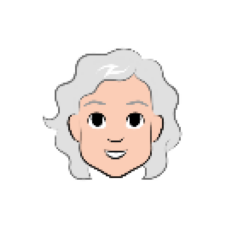

In [ ]:
for x in X_train:
    plt.axis("off")
    plt.imshow((x * 255).astype("int32"))
    break

In [ ]:
#X_train = X_train.reshape((X_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

In [ ]:
!mkdir /content/datas_2/generate_img2

In [ ]:
!ls /content/datas_2/

cartoonset10k  cartoonset10k.tgz  generate_img2


In [ ]:
import pandas as pd

#x_train = x_train[y_train.flatten() == 6]
#X_train = X_train.reshape((X_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 32
save_dir = '/content/datas_2/generate_img2'


D_loss = []
G_loss = []

start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size,
    latent_dim))

    generated_images = generator.predict(random_latent_vectors)
    stop = start + batch_size
    real_images = X_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    labels = np.concatenate([np.ones((batch_size, 1)),
    np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    random_latent_vectors = np.random.normal(size=(batch_size,
                latent_dim))

    misleading_targets = np.zeros((batch_size, 1))
    a_loss = gan.train_on_batch(random_latent_vectors,
                misleading_targets)
    D_loss.append(d_loss)
    G_loss.append(a_loss)
    start += batch_size
    if start > len(X_train) - batch_size:
        start = 0

    if step % 100 == 0:
        gan.save_weights('gan.h5')
        #print('discriminator loss:', d_loss)
        #print('adversarial loss:', a_loss)

        img = keras.preprocessing.image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir,
            'generated_frog' + str(step) + '.png'))
        img = keras.preprocessing.image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir,
            'real_frog' + str(step) + '.png'))

df = pd.DataFrame({'D_loss': D_loss, 'G_loss': G_loss})
df

,D_loss,G_loss
0,0.344470,1.555267
1,0.270311,2.365335
2,0.304007,2.519466
3,0.255606,1.891508
4,0.166078,3.024482
...,...,...
9995,0.116774,20.152317
9996,0.028722,21.332079
9997,0.078901,21.935266
9998,-0.053156,29.019814


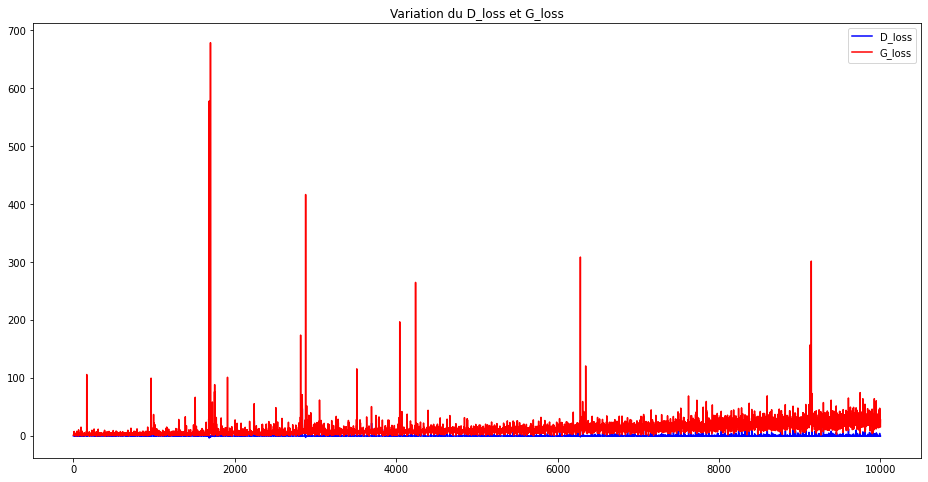

In [ ]:
import matplotlib.pyplot as plt

x = range(1, len(D_loss) + 1)
plt.figure(figsize=(35, 8))
plt.subplot(1, 2, 1)
plt.plot(x, D_loss, 'b', label='D_loss')
plt.plot(x, G_loss, 'r', label='G_loss')
plt.title('Variation du D_loss et G_loss')
plt.legend()

In [ ]:
#!rm -fr /content/datas_2/generate_img2

In [ ]:
!ls 

datas_2  gan.h5  sample_data
